Downloading...
From: https://drive.google.com/uc?id=1YneJRJ6DwDHaBuiQkGLOVjh1GJT_TGaG
To: c:\Users\Gabo\Desktop\PROYECTOFINAL\movies_dataset.csv
100%|██████████| 34.4M/34.4M [00:18<00:00, 1.87MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=15VvN0yeFgkFEmL_y4BG8OWettq6dTEPu
From (redirected): https://drive.google.com/uc?id=15VvN0yeFgkFEmL_y4BG8OWettq6dTEPu&confirm=t&uuid=d7de13c5-53d8-4207-9150-c2788e98ec1e
To: c:\Users\Gabo\Desktop\PROYECTOFINAL\credits.csv
100%|██████████| 190M/190M [01:36<00:00, 1.96MB/s] 


Valores nulos por columna:
 belongs_to_collection    40955
original_language           11
overview                   941
runtime                    246
status                      80
tagline                  25027
actor                     2355
director                   836
dtype: int64
Cantidad de filas duplicadas: 92

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45452 entries, 0 to 45451
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  4497 non-null   object        
 1   budget                 45452 non-null  float64       
 2   genres                 45452 non-null  object        
 3   id                     45452 non-null  object        
 4   original_language      45441 non-null  object        
 5   overview               44511 non-null  object        
 6   popularity             45452 non-null  object        
 7   produ

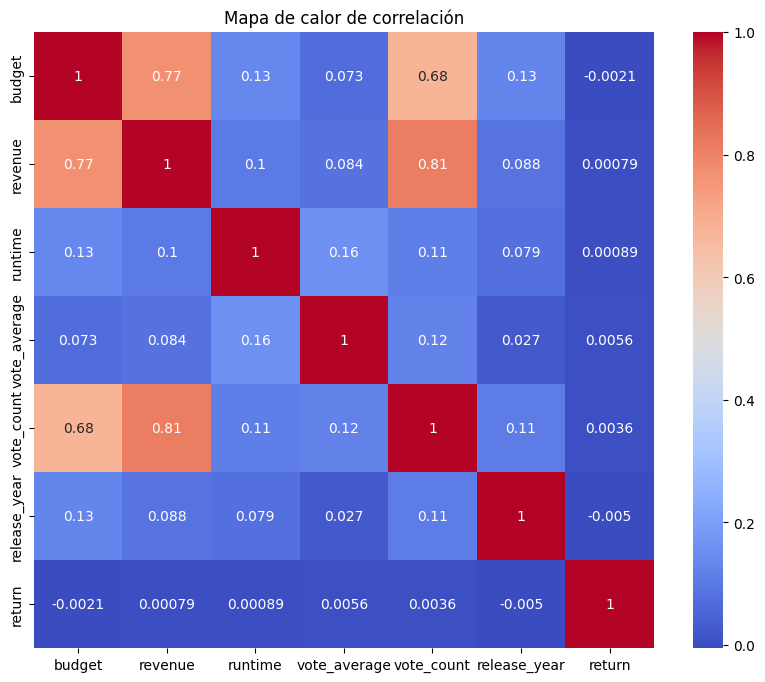

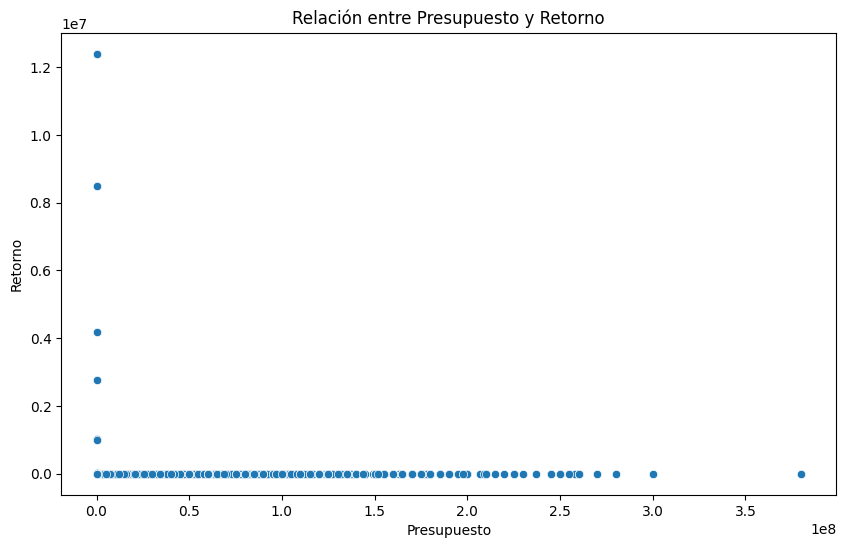

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

# Descargar los archivos desde Google Drive
movies_url = 'https://drive.google.com/uc?id=1YneJRJ6DwDHaBuiQkGLOVjh1GJT_TGaG'
credits_url = 'https://drive.google.com/uc?id=15VvN0yeFgkFEmL_y4BG8OWettq6dTEPu'

movies_path = 'movies_dataset.csv'
credits_path = 'credits.csv'

# Descarga de los archivos
gdown.download(movies_url, movies_path, quiet=False)
gdown.download(credits_url, credits_path, quiet=False)

# Cargar los datasets con el parámetro low_memory=False para evitar el DtypeWarning
movies_df = pd.read_csv(movies_path, low_memory=False)
credits_df = pd.read_csv(credits_path, low_memory=False)

# Paso 1: Desanidar campos (ejemplo para 'belongs_to_collection')
def extract_name_from_dict(column):
    def safe_eval(val):
        if not isinstance(val, str) or val in ["{}", ""]:
            return None
        try:
            parsed_val = ast.literal_eval(val)
            return parsed_val.get('name') if isinstance(parsed_val, dict) else None
        except (ValueError, SyntaxError):
            return None
    
    return column.apply(safe_eval)

movies_df['belongs_to_collection'] = movies_df['belongs_to_collection'].fillna("").astype(str)
movies_df['belongs_to_collection'] = extract_name_from_dict(movies_df['belongs_to_collection'])

# Paso 2: Limpiar y convertir la columna 'budget' a float
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce').fillna(0).astype(float)

# Paso 3: Imputar valores nulos en 'revenue' y convertir a float
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce').fillna(0).astype(float)

# Paso 4: Formato de fecha y creación de 'release_year'
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df = movies_df.dropna(subset=['release_date'])
movies_df['release_year'] = movies_df['release_date'].dt.year

# Paso 5: Crear la columna 'return'
movies_df['return'] = movies_df.apply(lambda x: x['revenue'] / x['budget'] if x['budget'] > 0 else 0, axis=1)

# Paso 6: Eliminar columnas no necesarias
columns_to_drop = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage']
movies_df = movies_df.drop(columns=columns_to_drop)

# Paso 7: Extraer actores y director de credits_df
def extract_actors(column):
    def safe_eval(val):
        if not isinstance(val, str) or val in ["[]", ""]:
            return None
        try:
            parsed_val = ast.literal_eval(val)
            return [item.get('name') for item in parsed_val[:3]] if isinstance(parsed_val, list) else None
        except (ValueError, SyntaxError):
            return None
    
    return column.apply(safe_eval)

def extract_director(column):
    def safe_eval(val):
        if not isinstance(val, str) or val in ["[]", ""]:
            return None
        try:
            parsed_val = ast.literal_eval(val)
            return next((item.get('name') for item in parsed_val if item.get('job') == 'Director'), None)
        except (ValueError, SyntaxError):
            return None
    
    return column.apply(safe_eval)

credits_df['actor'] = extract_actors(credits_df['cast'])
credits_df['director'] = extract_director(credits_df['crew'])

# Convertir la columna 'id' de ambos dataframes a tipo str
movies_df['id'] = movies_df['id'].astype(str)
credits_df['id'] = credits_df['id'].astype(str)

# Paso 8: Combinar movies_df con credits_df en la columna 'id'
movies_df = movies_df.merge(credits_df[['id', 'actor', 'director']], on='id', how='left')

# Paso 9: Análisis de Nulos
null_counts = movies_df.isnull().sum()
print("Valores nulos por columna:\n", null_counts[null_counts > 0])

# Paso 10: Verificación de valores duplicados
movies_df['actor'] = movies_df['actor'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
duplicate_count = movies_df.duplicated().sum()
print(f"Cantidad de filas duplicadas: {duplicate_count}")

# Volver a convertir 'actor' a listas (opcional)
movies_df['actor'] = movies_df['actor'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

# Paso 11: Tipos de datos y chequeo general
print("\nInformación del DataFrame:")
print(movies_df.info())

# Paso 12: Análisis estadístico descriptivo
print("\nEstadísticas descriptivas de las columnas numéricas:")
print(movies_df.describe())

# Paso 13: Análisis de correlación bivariada (solo columnas numéricas)
numeric_cols = movies_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
print("\nMatriz de correlación:")
print(correlation_matrix)

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Mapa de calor de correlación")
plt.show()

# Paso 14: Análisis de relación entre presupuesto y retorno
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_df, x='budget', y='return')
plt.title("Relación entre Presupuesto y Retorno")
plt.xlabel("Presupuesto")
plt.ylabel("Retorno")
plt.show()

# Paso 15: Análisis de frecuencia de géneros (si aplica)
if 'genre' in movies_df.columns:
    plt.figure(figsize=(10, 6))
    movies_df['genre'].value_counts().head(10).plot(kind='bar')
    plt.title("Frecuencia de Géneros")
    plt.xlabel("Género")
    plt.ylabel("Conteo")
    plt.show()

# Guardar el DataFrame procesado en formato CSV
movies_df.to_csv('movies_dataset_procesado.csv', index=False)
